<a href="https://colab.research.google.com/github/QuickLearner171998/CapsNet/blob/master/Caps_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
import torch
print(torch.__version__)

1.3.0+cu100


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets, transforms

from time import time

USE_CUDA = True

## CIFAR-10 data loader/generator.

Code below setups image generators from folder './data'

Normalization values for CIFAR10 are taken from pytorch website (usual normalization values for the task).

In [0]:
class Cifar10:
    def __init__(self, batch_size):
        dataset_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                   ])

        train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=dataset_transform)
        test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=dataset_transform)
        
        self.train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)       

## Network

Recall the architecture of CapsNet. This tutorial walks you through building process of it. Note that actual values of parameters such as "number of capsules", "number of filters in the first layer" etc. are not taken from MNIST implementation in the original paper, but instead from CIFAR10 implementation.

### Pre-capsule layer

This is a usual convolution layer that extracts basic features from images.

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=3, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=1
                             )

    def forward(self, x):
        return F.relu(self.conv(x))

### First capsule layer (PrimaryCaps)

This is the second layer of the network and the first one which contains capsules (recall that capsules are just groups of neurons).

The squash operation is the following one:

\begin{align}
v_j & = \frac{(\|s_j\|^2)}{(1 + \|s_j\|^2)} \frac{s_j}{\|s_j\|}\\
\end{align}

It takes a vector s_j as input, normalizes it to unit norm and then adds some non-linearity so that large vectors become close to 1 and small vectors close to zero. Recall that it is needed to enforce the property of v_j's norm being the probability (or certainty) that object is detected by the capsule v_j.

In [0]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=64, kernel_size=9):
        super(PrimaryCaps, self).__init__()

        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0) 
                          for _ in range(num_capsules)])
    
    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), 64 * 8 * 8, -1)
        return self.squash(u)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

### Second capsule layer (DigitCaps)

This is the final layer of the network and the one that contains digit-capsules (or in case of CIFAR10 - class-capsules) which predict the class on the image.

Below you may see the dynamic routing algorithm from the original paper under the forward section of the layer.

![alt text](https://cdn-images-1.medium.com/max/2000/1*ukE9EQ6Yd6IPIu1cLJWSEQ.png)

In [0]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=64 * 8 * 8, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)
            
            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

### Reconstruction part of network (decoder)

This is the second task for the network, namely, to reconstruct the image from the final class-capsules. 

This is a useful technique of regularization to prevent overfitting and also to enforce the property of capsules representing the 'instantiation parameters' of the object. In other words, final capsule should contain information about the class it predicts and that information (implicitly) may be: rotation angle, distortion, illumination etc.

The reconstruction is done by a simple decoder (stack of fully-connected layers). Below is the picture for MNIST.

![alt text](https://raw.githubusercontent.com/deepblacksky/capsnet-tensorflow/master/images/recong.png)

In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024*3),
            nn.Sigmoid()
        )
        
    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes)
        
        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(10))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=Variable(max_length_indices.squeeze(1).data))
        
        reconstructions = self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), -1))
        reconstructions = reconstructions.view(-1, 3, 32, 32)
        
        return reconstructions, masked

### Full network (CapsNet)

This is a final forward pass for the whole network. The only new part here is the custom loss from the original paper.

![alt text](https://cdn-images-1.medium.com/max/1493/1*y-bVFuiLReqSSdmdZ6wAmA.png)

In [0]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
        
        self.mse_loss = nn.MSELoss()
        
    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked
    
    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)
    
    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        left = (F.relu(0.9 - v_c)**2).view(batch_size, -1)
        right = (F.relu(v_c - 0.1)**2).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss
    
    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

Here the model is compiled with Adam optimizer with basic parameters.

In [0]:
capsule_net = CapsNet()
if USE_CUDA:
    capsule_net = capsule_net.cuda()
optimizer = Adam(capsule_net.parameters())

## Training

Note that one epoch takes a lot of time even on GPU, so don't rush and plan everything ahead and try to justify your ideas prior to implementing them.

In [0]:
batch_size = 8
# dataset = Mnist(batch_size)
dataset = Cifar10(batch_size)

n_epochs = 5


for epoch in range(n_epochs):
    ep_start = time()
    capsule_net.train()
    train_loss = 0
    train_accuracy = 0
    for batch_id, (data, target) in enumerate(dataset.train_loader):
        st = time()

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()

        train_loss = train_loss+loss.data
        
        tr_accuracy = sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                          np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size)
        train_accuracy += tr_accuracy
        if batch_id % 10 == 0 or batch_id == 99:
            print ("train accuracy [batch {}]:".format(batch_id), tr_accuracy)
            print ("Train loss:{}\n".format(loss.data))
        en = time()
#         print 'Sec per batch', round(en-st, 2)
    ep_end = time()
    print ('Total train loss', train_loss / len(dataset.train_loader))
    print ('Total train accuracy', train_accuracy / len(dataset.train_loader))
    print ('Total time for training an epoch: {}'.format(int(ep_end - ep_start))  )      
    capsule_net.eval()
    test_loss = 0
    test_accuracy = 0
    for batch_id, (data, target) in enumerate(dataset.test_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        test_loss += loss.data
        ts_accuracy = sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                          np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size)
        test_accuracy += ts_accuracy
        if batch_id % 25 == 0 or batch_id == 99:
            print ("test accuracy [batch {}]:".format(batch_id), ts_accuracy)
    
    print ('Total test loss', test_loss / len(dataset.test_loader))
    print ('Total test accuracy', test_accuracy / len(dataset.test_loader))

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


train accuracy [batch 0]: 0.75
Train loss:0.44040122628211975

train accuracy [batch 10]: 0.75
Train loss:0.256026953458786

train accuracy [batch 20]: 0.25
Train loss:0.3877621591091156

train accuracy [batch 30]: 0.5
Train loss:0.3283441364765167

train accuracy [batch 40]: 0.625
Train loss:0.221501424908638

train accuracy [batch 50]: 0.625
Train loss:0.2758632302284241

train accuracy [batch 60]: 0.5
Train loss:0.3989644944667816

train accuracy [batch 70]: 0.5
Train loss:0.5103580951690674

train accuracy [batch 80]: 0.875
Train loss:0.2092967927455902

train accuracy [batch 90]: 0.25
Train loss:0.3581005930900574

train accuracy [batch 99]: 0.625
Train loss:0.2962380349636078

train accuracy [batch 100]: 0.375
Train loss:0.45387619733810425

train accuracy [batch 110]: 0.5
Train loss:0.3117087781429291

train accuracy [batch 120]: 0.5
Train loss:0.24584147334098816

train accuracy [batch 130]: 0.625
Train loss:0.4087778627872467

train accuracy [batch 140]: 0.5
Train loss:0.36852

## Reconstructions

Here you can view the reconstructions obtained by your CapsNet. Nothing special here, just fun to visualize them. Actually, for mnist the reconstructions are great, however for CIFAR10 they are rubbish (see the original paper for clues on that).

Be careful when running reconstructions after `keyboard_interrupt`, because this may result in wrong input-target values.

In [0]:
import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    "Plot the six MNIST images separately."
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

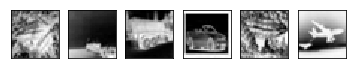

In [0]:
plot_images_separately(data[:6,0].data.cpu().numpy())

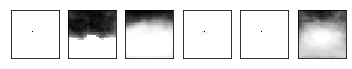

In [0]:
plot_images_separately(reconstructions[:6,0].data.cpu().numpy())

### To-Do

- Stack more convolutional layers before capsule layers.
- Increase the size of the capsule layers (more capsules, larger capsules etc.). Note that it may take a lot of time.
- Play with number of routing iterations in forward pass.
- Play with kernel size of convolutions in the first layer (don't forget to change parameters of subsequent layers).
- Play with kernel size of capsules in the second layer (again, pay attention to the parameters of subsequent computations).

- Try different variants of original implementation's loss function (change m+, m-, lambda, get rid of square etc.).
- Try different loss functions (make it pure Hinge or pure MSE, maybe even cross-entropy!).
- Try different implementation of capsules (not usual convolution operation, but maybe fully connected groups of neurons).
- Try different non-linearities for capsules (changing ^2 to ^4 doesn't count!).
- Try different weights for reconstruction loss.

